In [1]:
#Imports
import numpy as np
import pandas as pd
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

# Import supplementary visualization code visuals.py
import visuals as vs

In [2]:
path = "C:\\Users\\rohit\\OneDrive\\Udacity ML\\machine-learning-master\\projects\\capstone\\Stock Time Series Analysis\\"
data = pd.read_csv(path+'ITC.NS.csv',index_col=[0],parse_dates=True,dayfirst=False)

In [3]:
#Remove NA's
data.dropna(inplace=True)
print (data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-04-23  276.000000  277.200012  275.000000  275.500000  275.500000   
2018-04-24  276.000000  278.850006  274.649994  276.000000  276.000000   
2018-04-25  275.500000  276.299988  272.700012  274.100006  274.100006   
2018-04-26  274.549988  279.100006  273.000000  278.250000  278.250000   
2018-04-27  279.600006  280.950012  278.399994  279.399994  279.399994   

                Volume  
Date                    
2018-04-23  11746220.0  
2018-04-24   8449353.0  
2018-04-25   4928817.0  
2018-04-26  20282977.0  
2018-04-27   9732842.0  


In [4]:
#Filter only relevant columns
df = data[['Open','High','Low','Close']]

In [5]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['RSI'] = ta.RSI(np.array(df['Close']),timeperiod=10)
df['ADX'] = ta.ADX(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=7)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']),0.2,0.2)
df['Williams-R'] = ta.WILLR(df['High'].values, df['Low'].values, df['Close'].values, 7)
df.dropna(inplace=True)

df_filtered = df[['H-L','O-C','RSI','ADX','SAR','Williams-R']]

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


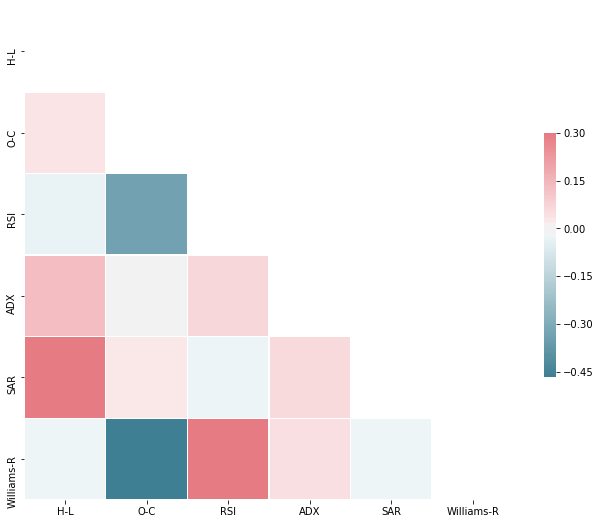

In [6]:
#Generate Correlation Matrix
corr = df_filtered.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
#Compare next day price with todays price
#If next days price greater than today then Price_change is 1 else 0
df['Price_Change'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [8]:
features = ['H-L','O-C','RSI','ADX','SAR','Williams-R']

X = df[features]
y = df['Price_Change']

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3620 samples.
Testing set has 905 samples.


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model

In [11]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [12]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

In [13]:
predicted = model.predict(X_test)

In [14]:
#Differenciate between up markets and down markets predictions
y_pred = (predicted > 0)

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

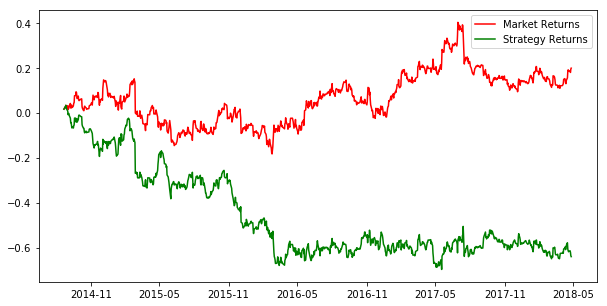

In [15]:
#Create a long short strategy
#If y_pred = True, go long, else short
import matplotlib.pyplot as plt

#Create dataframe to predict out of sample data
df['y_pred'] = np.NaN
df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
long_short_strategy = df.dropna()

#Get Next Day Returns
long_short_strategy['Tomorrows Returns'] = 0.
long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

#If Signal is True, go Long else go Short
long_short_strategy['Strategy Returns'] = 0.
long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
#Generate cumulative returns
long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])

#Plot the data
plt.figure(figsize=(10,5))
plt.plot(long_short_strategy['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(long_short_strategy['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [21]:
long_short_strategy.to_clipboard()

In [16]:
pred_df = pd.DataFrame(y_pred.flatten(),index=y_test.index,columns=['Pred'])

compare_df = pd.concat([y_test,pred_df.astype(int)],join='outer',axis=1)

In [17]:
metrics.accuracy_score(y_test,y_pred)

0.51602209944751376

In [18]:
def equity_vol(rtn_series):
    '''
    daily return series
    '''
    
    vol = np.std(rtn_series)*np.sqrt(252)
    
    return vol

def equity_return(rtn_series):
    '''
    daily return series
    '''
    rtn_series.fillna(0, inplace=True)    
    
    equity_line = 100*(1+np.cumsum(rtn_series))
    
    equity_line_rtn = (equity_line.ix[-1]/100)**(252.0/(len(rtn_series)-1)) -1
    
    return equity_line_rtn

In [19]:
print (equity_vol(long_short_strategy['Strategy Returns']))
print (equity_vol(long_short_strategy['Tomorrows Returns']))

print (equity_return(long_short_strategy['Strategy Returns']))
print (equity_return(long_short_strategy['Tomorrows Returns']))

0.259048335493
0.259268248014
-0.247577369219
0.0517676037534


C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [24]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0)


# The parameters list you wish to tune
parameters = {'penalty':['l1','l2'],
              'C':[0.1,0.5,1.0,2.0,]}

# Make an fbeta_score scoring object
def performance_metric(y_true, y_predict,beta=0.5):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true,y_predict)
    
    # Return the score
    return score

scorer = make_scorer(performance_metric)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=clf,param_grid=parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


In [25]:
best_clf

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
best_model = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
best_model = best_model.fit (X_train,y_train)
predicted = best_model.predict(X_test)

In [28]:
#Differenciate between up markets and down markets predictions
y_pred = (predicted > 0)

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

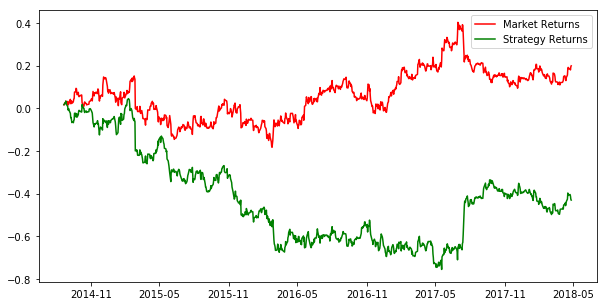

In [29]:
#Create a long short strategy
#If y_pred = True, go long, else short
import matplotlib.pyplot as plt

#Create dataframe to predict out of sample data
df['y_pred'] = np.NaN
df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
long_short_strategy = df.dropna()

#Get Next Day Returns
long_short_strategy['Tomorrows Returns'] = 0.
long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

#If Signal is True, go Long else go Short
long_short_strategy['Strategy Returns'] = 0.
long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
#Generate cumulative returns
long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])

#Plot the data
plt.figure(figsize=(10,5))
plt.plot(long_short_strategy['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(long_short_strategy['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()